In [35]:
import torch
import torch.nn as nn
import torch.optim as optim
import matplotlib.pyplot as plt
from tqdm import tqdm
from torchvision import datasets, transforms
from skimage.metrics import structural_similarity as ssim
import numpy as np
from sklearn.model_selection import KFold

In [36]:
class Autoenconder(nn.Module):
    def __init__(self):
        super().__init__() 
        self.encoder = nn.Sequential(
            nn.Linear(28*28, 256),
            nn.ReLU(),
            nn.Linear(256, 128),
            nn.ReLU(),
            nn.Linear(128, 32),  
        )
    
        self.decoder = nn.Sequential(
            nn.Linear(32, 128),
            nn.ReLU(),
            nn.Linear(128, 256),
            nn.ReLU(),
            nn.Linear(256, 28*28),
            nn.Sigmoid(),
        )

    def forward(self, x):
        x = x.view(-1, 28*28)
        z = self.encoder(x)
        out = self.decoder(z)
        return out


In [37]:
transform = transforms.ToTensor()
dataset = datasets.FashionMNIST(
    './data', train=True, transform=transform, download=True
)


In [38]:
k = 5  # número de folds
kf = KFold(n_splits=k, shuffle=True, random_state=42)

In [ ]:
from sklearn.model_selection import KFold
from torch.utils.data import Subset, DataLoader

device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

k = 5
num_epochs = 50

criterion = nn.MSELoss()
kf = KFold(n_splits=k, shuffle=True, random_state=42)

all_train_losses = []
all_val_losses = []
all_ssim = []

for fold, (train_idx, val_idx) in enumerate(kf.split(dataset)):
    print(f"    FOLD {fold+1}/{k}")

    train_subset = Subset(dataset, train_idx)
    val_subset   = Subset(dataset, val_idx)

    training_loader = DataLoader(train_subset, batch_size=64, shuffle=True)
    validation_loader = DataLoader(val_subset, batch_size=64, shuffle=False)

    model = Autoenconder().to(device)
    optimizer = optim.Adam(model.parameters(), lr=1e-3, weight_decay=1e-5)

    train_losses = []
    val_losses = []
    ssim_list = []

    for epoch in range(1, num_epochs + 1):
        print(f"\n[Fold {fold+1}/{k}] [Epoch {epoch}/{num_epochs}]")

        model.train()
        running_loss = 0

        train_bar = tqdm(training_loader, desc="🔵 Treinando", leave=False)

        for images, _ in train_bar:
            images = images.reshape(images.size(0), -1).to(device)

            optimizer.zero_grad()
            outputs = model(images)
            loss = criterion(outputs, images)
            loss.backward()
            optimizer.step()

            running_loss += loss.item()
            train_bar.set_postfix(loss=f"{loss.item():.4f}")

        train_loss = running_loss / len(training_loader)
        train_losses.append(train_loss)

        model.eval()
        running_val_loss = 0
        running_val_ssim = 0

        val_bar = tqdm(validation_loader, desc="🟣 Validando", leave=False)

        with torch.no_grad():
            for images, _ in val_bar:
                images = images.to(device)
                flat = images.reshape(images.size(0), -1)

                outputs = model(flat)
                outputs = outputs.reshape(-1, 1, 28, 28)

                loss = criterion(outputs.reshape(images.size(0), -1), flat)

                batch_ssim = 0
                for i in range(images.size(0)):
                    img_np = images[i].cpu().numpy().astype("float32")
                    out_np = outputs[i].cpu().numpy().astype("float32")
                    batch_ssim += ssim(img_np.squeeze(), out_np.squeeze(), data_range=1.0)

                batch_ssim /= images.size(0)

                running_val_loss += loss.item()
                running_val_ssim += batch_ssim

                val_bar.set_postfix(
                    val_loss=f"{loss.item():.4f}",
                    ssim=f"{batch_ssim:.4f}"
                )

        val_loss = running_val_loss / len(validation_loader)
        mean_ssim = running_val_ssim / len(validation_loader)

        val_losses.append(val_loss)
        ssim_list.append(mean_ssim)

        print(f" Loss Treino: {train_loss:.4f} | Loss Val: {val_loss:.4f} | SSIM: {mean_ssim:.4f}")

    # salva resultados deste fold
    all_train_losses.append(train_losses)
    all_val_losses.append(val_losses)
    all_ssim.append(ssim_list)

print("\nTreinamento k-fold concluído! 🎉")



    FOLD 1/5

[Fold 1/5] [Epoch 1/50]


 Loss Treino: 0.0353 | Loss Val: 0.0238 | SSIM: 0.5503

[Fold 1/5] [Epoch 2/50]


 Loss Treino: 0.0212 | Loss Val: 0.0198 | SSIM: 0.5980

[Fold 1/5] [Epoch 3/50]


 Loss Treino: 0.0189 | Loss Val: 0.0181 | SSIM: 0.6194

[Fold 1/5] [Epoch 4/50]


 Loss Treino: 0.0176 | Loss Val: 0.0172 | SSIM: 0.6373

[Fold 1/5] [Epoch 5/50]


 Loss Treino: 0.0166 | Loss Val: 0.0162 | SSIM: 0.6509

[Fold 1/5] [Epoch 6/50]


 Loss Treino: 0.0159 | Loss Val: 0.0158 | SSIM: 0.6551

[Fold 1/5] [Epoch 7/50]


 Loss Treino: 0.0155 | Loss Val: 0.0153 | SSIM: 0.6594

[Fold 1/5] [Epoch 8/50]


 Loss Treino: 0.0153 | Loss Val: 0.0152 | SSIM: 0.6635

[Fold 1/5] [Epoch 9/50]


 Loss Treino: 0.0150 | Loss Val: 0.0150 | SSIM: 0.6625

[Fold 1/5] [Epoch 10/50]


 Loss Treino: 0.0149 | Loss Val: 0.0150 | SSIM: 0.6636

[Fold 1/5] [Epoch 11/50]


 Loss Treino: 0.0147 | Loss Val: 0.0148 | SSIM: 0.6693

[Fold 1/5] [Epoch 12/50]


 Loss Treino: 0.0146 | Loss Val: 0.0146 | SSIM: 0.6706

[Fold 1/5] [Epoch 13/50]


 Loss Treino: 0.0145 | Loss Val: 0.0146 | SSIM: 0.6710

[Fold 1/5] [Epoch 14/50]


 Loss Treino: 0.0144 | Loss Val: 0.0144 | SSIM: 0.6755

[Fold 1/5] [Epoch 15/50]


 Loss Treino: 0.0143 | Loss Val: 0.0142 | SSIM: 0.6775

[Fold 1/5] [Epoch 16/50]


 Loss Treino: 0.0142 | Loss Val: 0.0143 | SSIM: 0.6729

[Fold 1/5] [Epoch 17/50]


 Loss Treino: 0.0141 | Loss Val: 0.0141 | SSIM: 0.6793

[Fold 1/5] [Epoch 18/50]


 Loss Treino: 0.0140 | Loss Val: 0.0139 | SSIM: 0.6797

[Fold 1/5] [Epoch 19/50]


 Loss Treino: 0.0139 | Loss Val: 0.0139 | SSIM: 0.6804

[Fold 1/5] [Epoch 20/50]


 Loss Treino: 0.0138 | Loss Val: 0.0138 | SSIM: 0.6830

[Fold 1/5] [Epoch 21/50]


 Loss Treino: 0.0136 | Loss Val: 0.0137 | SSIM: 0.6833

[Fold 1/5] [Epoch 22/50]


 Loss Treino: 0.0135 | Loss Val: 0.0135 | SSIM: 0.6899

[Fold 1/5] [Epoch 23/50]


 Loss Treino: 0.0134 | Loss Val: 0.0135 | SSIM: 0.6878

[Fold 1/5] [Epoch 24/50]


 Loss Treino: 0.0133 | Loss Val: 0.0133 | SSIM: 0.6880

[Fold 1/5] [Epoch 25/50]


 Loss Treino: 0.0132 | Loss Val: 0.0135 | SSIM: 0.6876

[Fold 1/5] [Epoch 26/50]


 Loss Treino: 0.0132 | Loss Val: 0.0133 | SSIM: 0.6914

[Fold 1/5] [Epoch 27/50]


 Loss Treino: 0.0131 | Loss Val: 0.0133 | SSIM: 0.6878

[Fold 1/5] [Epoch 28/50]


 Loss Treino: 0.0131 | Loss Val: 0.0131 | SSIM: 0.6930

[Fold 1/5] [Epoch 29/50]


 Loss Treino: 0.0130 | Loss Val: 0.0131 | SSIM: 0.6934

[Fold 1/5] [Epoch 30/50]


 Loss Treino: 0.0130 | Loss Val: 0.0131 | SSIM: 0.6920

[Fold 1/5] [Epoch 31/50]


 Loss Treino: 0.0130 | Loss Val: 0.0131 | SSIM: 0.6927

[Fold 1/5] [Epoch 32/50]


 Loss Treino: 0.0130 | Loss Val: 0.0131 | SSIM: 0.6917

[Fold 1/5] [Epoch 33/50]


 Loss Treino: 0.0129 | Loss Val: 0.0130 | SSIM: 0.6907

[Fold 1/5] [Epoch 34/50]


 Loss Treino: 0.0129 | Loss Val: 0.0131 | SSIM: 0.6883

[Fold 1/5] [Epoch 35/50]


 Loss Treino: 0.0129 | Loss Val: 0.0131 | SSIM: 0.6931

[Fold 1/5] [Epoch 36/50]


 Loss Treino: 0.0129 | Loss Val: 0.0130 | SSIM: 0.6896

[Fold 1/5] [Epoch 37/50]


 Loss Treino: 0.0129 | Loss Val: 0.0130 | SSIM: 0.6924

[Fold 1/5] [Epoch 38/50]


 Loss Treino: 0.0129 | Loss Val: 0.0129 | SSIM: 0.6956

[Fold 1/5] [Epoch 39/50]


 Loss Treino: 0.0128 | Loss Val: 0.0130 | SSIM: 0.6852

[Fold 1/5] [Epoch 40/50]


 Loss Treino: 0.0128 | Loss Val: 0.0129 | SSIM: 0.6926

[Fold 1/5] [Epoch 41/50]


 Loss Treino: 0.0128 | Loss Val: 0.0129 | SSIM: 0.6944

[Fold 1/5] [Epoch 42/50]


 Loss Treino: 0.0128 | Loss Val: 0.0129 | SSIM: 0.6932

[Fold 1/5] [Epoch 43/50]


 Loss Treino: 0.0128 | Loss Val: 0.0129 | SSIM: 0.6941

[Fold 1/5] [Epoch 44/50]


 Loss Treino: 0.0128 | Loss Val: 0.0129 | SSIM: 0.6938

[Fold 1/5] [Epoch 45/50]


 Loss Treino: 0.0127 | Loss Val: 0.0128 | SSIM: 0.6963

[Fold 1/5] [Epoch 46/50]


 Loss Treino: 0.0127 | Loss Val: 0.0128 | SSIM: 0.6917

[Fold 1/5] [Epoch 47/50]


 Loss Treino: 0.0127 | Loss Val: 0.0128 | SSIM: 0.6939

[Fold 1/5] [Epoch 48/50]


 Loss Treino: 0.0127 | Loss Val: 0.0128 | SSIM: 0.6964

[Fold 1/5] [Epoch 49/50]


 Loss Treino: 0.0127 | Loss Val: 0.0128 | SSIM: 0.6937

[Fold 1/5] [Epoch 50/50]


 Loss Treino: 0.0127 | Loss Val: 0.0129 | SSIM: 0.6936

    FOLD 2/5

[Fold 2/5] [Epoch 1/50]


 Loss Treino: 0.0345 | Loss Val: 0.0222 | SSIM: 0.5650

[Fold 2/5] [Epoch 2/50]


 Loss Treino: 0.0210 | Loss Val: 0.0196 | SSIM: 0.6005

[Fold 2/5] [Epoch 3/50]


 Loss Treino: 0.0190 | Loss Val: 0.0182 | SSIM: 0.6184

[Fold 2/5] [Epoch 4/50]


 Loss Treino: 0.0179 | Loss Val: 0.0170 | SSIM: 0.6391

[Fold 2/5] [Epoch 5/50]


 Loss Treino: 0.0167 | Loss Val: 0.0160 | SSIM: 0.6474

[Fold 2/5] [Epoch 6/50]


 Loss Treino: 0.0160 | Loss Val: 0.0156 | SSIM: 0.6526

[Fold 2/5] [Epoch 7/50]


 Loss Treino: 0.0156 | Loss Val: 0.0155 | SSIM: 0.6587

[Fold 2/5] [Epoch 8/50]


 Loss Treino: 0.0153 | Loss Val: 0.0152 | SSIM: 0.6633

[Fold 2/5] [Epoch 9/50]


 Loss Treino: 0.0150 | Loss Val: 0.0149 | SSIM: 0.6643

[Fold 2/5] [Epoch 10/50]


 Loss Treino: 0.0149 | Loss Val: 0.0147 | SSIM: 0.6695

[Fold 2/5] [Epoch 11/50]


 Loss Treino: 0.0147 | Loss Val: 0.0145 | SSIM: 0.6722

[Fold 2/5] [Epoch 12/50]


 Loss Treino: 0.0146 | Loss Val: 0.0145 | SSIM: 0.6722

[Fold 2/5] [Epoch 13/50]


 Loss Treino: 0.0144 | Loss Val: 0.0142 | SSIM: 0.6741

[Fold 2/5] [Epoch 14/50]


 Loss Treino: 0.0143 | Loss Val: 0.0141 | SSIM: 0.6775

[Fold 2/5] [Epoch 15/50]


 Loss Treino: 0.0141 | Loss Val: 0.0138 | SSIM: 0.6808

[Fold 2/5] [Epoch 16/50]


 Loss Treino: 0.0138 | Loss Val: 0.0137 | SSIM: 0.6809

[Fold 2/5] [Epoch 17/50]


 Loss Treino: 0.0136 | Loss Val: 0.0135 | SSIM: 0.6837

[Fold 2/5] [Epoch 18/50]


 Loss Treino: 0.0135 | Loss Val: 0.0133 | SSIM: 0.6897

[Fold 2/5] [Epoch 19/50]


 Loss Treino: 0.0134 | Loss Val: 0.0133 | SSIM: 0.6888

[Fold 2/5] [Epoch 20/50]


 Loss Treino: 0.0134 | Loss Val: 0.0133 | SSIM: 0.6863

[Fold 2/5] [Epoch 21/50]


 Loss Treino: 0.0133 | Loss Val: 0.0133 | SSIM: 0.6880

[Fold 2/5] [Epoch 22/50]


 Loss Treino: 0.0133 | Loss Val: 0.0133 | SSIM: 0.6855

[Fold 2/5] [Epoch 23/50]


 Loss Treino: 0.0132 | Loss Val: 0.0132 | SSIM: 0.6866

[Fold 2/5] [Epoch 24/50]


 Loss Treino: 0.0132 | Loss Val: 0.0131 | SSIM: 0.6890

[Fold 2/5] [Epoch 25/50]


 Loss Treino: 0.0131 | Loss Val: 0.0131 | SSIM: 0.6912

[Fold 2/5] [Epoch 26/50]


 Loss Treino: 0.0131 | Loss Val: 0.0131 | SSIM: 0.6885

[Fold 2/5] [Epoch 27/50]


 Loss Treino: 0.0131 | Loss Val: 0.0131 | SSIM: 0.6912

[Fold 2/5] [Epoch 28/50]


 Loss Treino: 0.0130 | Loss Val: 0.0131 | SSIM: 0.6906

[Fold 2/5] [Epoch 29/50]


 Loss Treino: 0.0130 | Loss Val: 0.0130 | SSIM: 0.6923

[Fold 2/5] [Epoch 30/50]


 Loss Treino: 0.0130 | Loss Val: 0.0131 | SSIM: 0.6879

[Fold 2/5] [Epoch 31/50]


 Loss Treino: 0.0130 | Loss Val: 0.0129 | SSIM: 0.6940

[Fold 2/5] [Epoch 32/50]


 Loss Treino: 0.0129 | Loss Val: 0.0130 | SSIM: 0.6919

[Fold 2/5] [Epoch 33/50]


 Loss Treino: 0.0129 | Loss Val: 0.0128 | SSIM: 0.6951

[Fold 2/5] [Epoch 34/50]


 Loss Treino: 0.0129 | Loss Val: 0.0128 | SSIM: 0.6920

[Fold 2/5] [Epoch 35/50]


 Loss Treino: 0.0129 | Loss Val: 0.0128 | SSIM: 0.6939

[Fold 2/5] [Epoch 36/50]


 Loss Treino: 0.0129 | Loss Val: 0.0129 | SSIM: 0.6913

[Fold 2/5] [Epoch 37/50]


 Loss Treino: 0.0129 | Loss Val: 0.0127 | SSIM: 0.6948

[Fold 2/5] [Epoch 38/50]


 Loss Treino: 0.0128 | Loss Val: 0.0129 | SSIM: 0.6942

[Fold 2/5] [Epoch 39/50]


 Loss Treino: 0.0128 | Loss Val: 0.0128 | SSIM: 0.6933

[Fold 2/5] [Epoch 40/50]


 Loss Treino: 0.0128 | Loss Val: 0.0128 | SSIM: 0.6914

[Fold 2/5] [Epoch 41/50]


 Loss Treino: 0.0128 | Loss Val: 0.0129 | SSIM: 0.6924

[Fold 2/5] [Epoch 42/50]


 Loss Treino: 0.0128 | Loss Val: 0.0127 | SSIM: 0.6946

[Fold 2/5] [Epoch 43/50]


 Loss Treino: 0.0128 | Loss Val: 0.0127 | SSIM: 0.6935

[Fold 2/5] [Epoch 44/50]


 Loss Treino: 0.0128 | Loss Val: 0.0127 | SSIM: 0.6961

[Fold 2/5] [Epoch 45/50]


 Loss Treino: 0.0128 | Loss Val: 0.0128 | SSIM: 0.6943

[Fold 2/5] [Epoch 46/50]


 Loss Treino: 0.0127 | Loss Val: 0.0128 | SSIM: 0.6920

[Fold 2/5] [Epoch 47/50]


 Loss Treino: 0.0127 | Loss Val: 0.0127 | SSIM: 0.6962

[Fold 2/5] [Epoch 48/50]


 Loss Treino: 0.0127 | Loss Val: 0.0127 | SSIM: 0.6933

[Fold 2/5] [Epoch 49/50]


 Loss Treino: 0.0127 | Loss Val: 0.0126 | SSIM: 0.6937

[Fold 2/5] [Epoch 50/50]


 Loss Treino: 0.0127 | Loss Val: 0.0127 | SSIM: 0.6935

    FOLD 3/5

[Fold 3/5] [Epoch 1/50]


 Loss Treino: 0.0343 | Loss Val: 0.0228 | SSIM: 0.5588

[Fold 3/5] [Epoch 2/50]


 Loss Treino: 0.0215 | Loss Val: 0.0202 | SSIM: 0.5946

[Fold 3/5] [Epoch 3/50]


 Loss Treino: 0.0192 | Loss Val: 0.0188 | SSIM: 0.6145

[Fold 3/5] [Epoch 4/50]


 Loss Treino: 0.0179 | Loss Val: 0.0173 | SSIM: 0.6354

[Fold 3/5] [Epoch 5/50]


 Loss Treino: 0.0169 | Loss Val: 0.0167 | SSIM: 0.6439

[Fold 3/5] [Epoch 6/50]


 Loss Treino: 0.0163 | Loss Val: 0.0160 | SSIM: 0.6532

[Fold 3/5] [Epoch 7/50]


 Loss Treino: 0.0157 | Loss Val: 0.0156 | SSIM: 0.6575

[Fold 3/5] [Epoch 8/50]


 Loss Treino: 0.0152 | Loss Val: 0.0152 | SSIM: 0.6671

[Fold 3/5] [Epoch 9/50]


 Loss Treino: 0.0149 | Loss Val: 0.0149 | SSIM: 0.6666

[Fold 3/5] [Epoch 10/50]


 Loss Treino: 0.0146 | Loss Val: 0.0148 | SSIM: 0.6736

[Fold 3/5] [Epoch 11/50]


 Loss Treino: 0.0144 | Loss Val: 0.0144 | SSIM: 0.6769

[Fold 3/5] [Epoch 12/50]


 Loss Treino: 0.0142 | Loss Val: 0.0144 | SSIM: 0.6762

[Fold 3/5] [Epoch 13/50]


 Loss Treino: 0.0141 | Loss Val: 0.0143 | SSIM: 0.6760

[Fold 3/5] [Epoch 14/50]


 Loss Treino: 0.0140 | Loss Val: 0.0141 | SSIM: 0.6797

[Fold 3/5] [Epoch 15/50]


 Loss Treino: 0.0139 | Loss Val: 0.0139 | SSIM: 0.6818

[Fold 3/5] [Epoch 16/50]


 Loss Treino: 0.0138 | Loss Val: 0.0138 | SSIM: 0.6816

[Fold 3/5] [Epoch 17/50]


 Loss Treino: 0.0137 | Loss Val: 0.0137 | SSIM: 0.6833

[Fold 3/5] [Epoch 18/50]


 Loss Treino: 0.0135 | Loss Val: 0.0136 | SSIM: 0.6839

[Fold 3/5] [Epoch 19/50]


 Loss Treino: 0.0134 | Loss Val: 0.0135 | SSIM: 0.6860

[Fold 3/5] [Epoch 20/50]


 Loss Treino: 0.0133 | Loss Val: 0.0134 | SSIM: 0.6872

[Fold 3/5] [Epoch 21/50]


 Loss Treino: 0.0133 | Loss Val: 0.0134 | SSIM: 0.6890

[Fold 3/5] [Epoch 22/50]


 Loss Treino: 0.0132 | Loss Val: 0.0133 | SSIM: 0.6911

[Fold 3/5] [Epoch 23/50]


 Loss Treino: 0.0132 | Loss Val: 0.0134 | SSIM: 0.6851

[Fold 3/5] [Epoch 24/50]


 Loss Treino: 0.0131 | Loss Val: 0.0133 | SSIM: 0.6874

[Fold 3/5] [Epoch 25/50]


 Loss Treino: 0.0131 | Loss Val: 0.0132 | SSIM: 0.6920

[Fold 3/5] [Epoch 26/50]


 Loss Treino: 0.0130 | Loss Val: 0.0131 | SSIM: 0.6911

[Fold 3/5] [Epoch 27/50]


 Loss Treino: 0.0130 | Loss Val: 0.0132 | SSIM: 0.6908

[Fold 3/5] [Epoch 28/50]


 Loss Treino: 0.0130 | Loss Val: 0.0130 | SSIM: 0.6918

[Fold 3/5] [Epoch 29/50]


 Loss Treino: 0.0129 | Loss Val: 0.0132 | SSIM: 0.6943

[Fold 3/5] [Epoch 30/50]


 Loss Treino: 0.0129 | Loss Val: 0.0130 | SSIM: 0.6910

[Fold 3/5] [Epoch 31/50]


 Loss Treino: 0.0129 | Loss Val: 0.0130 | SSIM: 0.6936

[Fold 3/5] [Epoch 32/50]


 Loss Treino: 0.0129 | Loss Val: 0.0130 | SSIM: 0.6937

[Fold 3/5] [Epoch 33/50]


 Loss Treino: 0.0129 | Loss Val: 0.0130 | SSIM: 0.6934

[Fold 3/5] [Epoch 34/50]


 Loss Treino: 0.0128 | Loss Val: 0.0130 | SSIM: 0.6957

[Fold 3/5] [Epoch 35/50]


 Loss Treino: 0.0128 | Loss Val: 0.0129 | SSIM: 0.6956

[Fold 3/5] [Epoch 36/50]


 Loss Treino: 0.0128 | Loss Val: 0.0131 | SSIM: 0.6886

[Fold 3/5] [Epoch 37/50]


 Loss Treino: 0.0128 | Loss Val: 0.0130 | SSIM: 0.6911

[Fold 3/5] [Epoch 38/50]


 Loss Treino: 0.0128 | Loss Val: 0.0130 | SSIM: 0.6913

[Fold 3/5] [Epoch 39/50]


 Loss Treino: 0.0128 | Loss Val: 0.0131 | SSIM: 0.6949

[Fold 3/5] [Epoch 40/50]


 Loss Treino: 0.0128 | Loss Val: 0.0129 | SSIM: 0.6912

[Fold 3/5] [Epoch 41/50]


 Loss Treino: 0.0128 | Loss Val: 0.0129 | SSIM: 0.6926

[Fold 3/5] [Epoch 42/50]


 Loss Treino: 0.0127 | Loss Val: 0.0128 | SSIM: 0.6921

[Fold 3/5] [Epoch 43/50]


 Loss Treino: 0.0127 | Loss Val: 0.0129 | SSIM: 0.6956

[Fold 3/5] [Epoch 44/50]


 Loss Treino: 0.0127 | Loss Val: 0.0128 | SSIM: 0.6935

[Fold 3/5] [Epoch 45/50]


 Loss Treino: 0.0127 | Loss Val: 0.0129 | SSIM: 0.6943

[Fold 3/5] [Epoch 46/50]


 Loss Treino: 0.0127 | Loss Val: 0.0129 | SSIM: 0.6948

[Fold 3/5] [Epoch 47/50]


 Loss Treino: 0.0127 | Loss Val: 0.0129 | SSIM: 0.6913

[Fold 3/5] [Epoch 48/50]


 Loss Treino: 0.0127 | Loss Val: 0.0129 | SSIM: 0.6942

[Fold 3/5] [Epoch 49/50]


 Loss Treino: 0.0127 | Loss Val: 0.0128 | SSIM: 0.6951

[Fold 3/5] [Epoch 50/50]


 Loss Treino: 0.0126 | Loss Val: 0.0128 | SSIM: 0.6970

    FOLD 4/5

[Fold 4/5] [Epoch 1/50]


 Loss Treino: 0.0339 | Loss Val: 0.0226 | SSIM: 0.5655

[Fold 4/5] [Epoch 2/50]


 Loss Treino: 0.0207 | Loss Val: 0.0195 | SSIM: 0.6040

[Fold 4/5] [Epoch 3/50]


 Loss Treino: 0.0185 | Loss Val: 0.0182 | SSIM: 0.6206

[Fold 4/5] [Epoch 4/50]


 Loss Treino: 0.0173 | Loss Val: 0.0170 | SSIM: 0.6387

[Fold 4/5] [Epoch 5/50]


 Loss Treino: 0.0166 | Loss Val: 0.0164 | SSIM: 0.6470

[Fold 4/5] [Epoch 6/50]


 Loss Treino: 0.0161 | Loss Val: 0.0160 | SSIM: 0.6547

[Fold 4/5] [Epoch 7/50]


 Loss Treino: 0.0156 | Loss Val: 0.0156 | SSIM: 0.6540

[Fold 4/5] [Epoch 8/50]


 Loss Treino: 0.0153 | Loss Val: 0.0151 | SSIM: 0.6628

[Fold 4/5] [Epoch 9/50]


 Loss Treino: 0.0150 | Loss Val: 0.0151 | SSIM: 0.6648

[Fold 4/5] [Epoch 10/50]


 Loss Treino: 0.0148 | Loss Val: 0.0148 | SSIM: 0.6696

[Fold 4/5] [Epoch 11/50]


 Loss Treino: 0.0146 | Loss Val: 0.0146 | SSIM: 0.6697

[Fold 4/5] [Epoch 12/50]


 Loss Treino: 0.0144 | Loss Val: 0.0144 | SSIM: 0.6723

[Fold 4/5] [Epoch 13/50]


 Loss Treino: 0.0142 | Loss Val: 0.0141 | SSIM: 0.6790

[Fold 4/5] [Epoch 14/50]


 Loss Treino: 0.0140 | Loss Val: 0.0142 | SSIM: 0.6808

[Fold 4/5] [Epoch 15/50]


 Loss Treino: 0.0139 | Loss Val: 0.0140 | SSIM: 0.6810

[Fold 4/5] [Epoch 16/50]


 Loss Treino: 0.0138 | Loss Val: 0.0138 | SSIM: 0.6825

[Fold 4/5] [Epoch 17/50]


 Loss Treino: 0.0137 | Loss Val: 0.0138 | SSIM: 0.6828

[Fold 4/5] [Epoch 18/50]


 Loss Treino: 0.0137 | Loss Val: 0.0137 | SSIM: 0.6837

[Fold 4/5] [Epoch 19/50]


 Loss Treino: 0.0136 | Loss Val: 0.0137 | SSIM: 0.6807

[Fold 4/5] [Epoch 20/50]


 Loss Treino: 0.0134 | Loss Val: 0.0134 | SSIM: 0.6865

[Fold 4/5] [Epoch 21/50]


 Loss Treino: 0.0133 | Loss Val: 0.0133 | SSIM: 0.6905

[Fold 4/5] [Epoch 22/50]


 Loss Treino: 0.0132 | Loss Val: 0.0133 | SSIM: 0.6895

[Fold 4/5] [Epoch 23/50]


 Loss Treino: 0.0132 | Loss Val: 0.0132 | SSIM: 0.6902

[Fold 4/5] [Epoch 24/50]


 Loss Treino: 0.0131 | Loss Val: 0.0133 | SSIM: 0.6899

[Fold 4/5] [Epoch 25/50]


 Loss Treino: 0.0130 | Loss Val: 0.0130 | SSIM: 0.6920

[Fold 4/5] [Epoch 26/50]


 Loss Treino: 0.0129 | Loss Val: 0.0131 | SSIM: 0.6891

[Fold 4/5] [Epoch 27/50]


 Loss Treino: 0.0128 | Loss Val: 0.0128 | SSIM: 0.6944

[Fold 4/5] [Epoch 28/50]


 Loss Treino: 0.0127 | Loss Val: 0.0129 | SSIM: 0.6965

[Fold 4/5] [Epoch 29/50]


 Loss Treino: 0.0127 | Loss Val: 0.0128 | SSIM: 0.6936

[Fold 4/5] [Epoch 30/50]


 Loss Treino: 0.0126 | Loss Val: 0.0127 | SSIM: 0.6976

[Fold 4/5] [Epoch 31/50]


 Loss Treino: 0.0126 | Loss Val: 0.0128 | SSIM: 0.6957

[Fold 4/5] [Epoch 32/50]


 Loss Treino: 0.0126 | Loss Val: 0.0126 | SSIM: 0.6978

[Fold 4/5] [Epoch 33/50]


 Loss Treino: 0.0125 | Loss Val: 0.0126 | SSIM: 0.6969

[Fold 4/5] [Epoch 34/50]


 Loss Treino: 0.0125 | Loss Val: 0.0127 | SSIM: 0.6965

[Fold 4/5] [Epoch 35/50]


 Loss Treino: 0.0125 | Loss Val: 0.0126 | SSIM: 0.6980

[Fold 4/5] [Epoch 36/50]


 Loss Treino: 0.0125 | Loss Val: 0.0126 | SSIM: 0.6996

[Fold 4/5] [Epoch 37/50]


 Loss Treino: 0.0125 | Loss Val: 0.0126 | SSIM: 0.6985

[Fold 4/5] [Epoch 38/50]


 Loss Treino: 0.0125 | Loss Val: 0.0128 | SSIM: 0.6938

[Fold 4/5] [Epoch 39/50]


 Loss Treino: 0.0124 | Loss Val: 0.0126 | SSIM: 0.6981

[Fold 4/5] [Epoch 40/50]


 Loss Treino: 0.0124 | Loss Val: 0.0126 | SSIM: 0.7008

[Fold 4/5] [Epoch 41/50]


 Loss Treino: 0.0124 | Loss Val: 0.0126 | SSIM: 0.6953

[Fold 4/5] [Epoch 42/50]


 Loss Treino: 0.0124 | Loss Val: 0.0125 | SSIM: 0.6991

[Fold 4/5] [Epoch 43/50]


 Loss Treino: 0.0124 | Loss Val: 0.0125 | SSIM: 0.7008

[Fold 4/5] [Epoch 44/50]


 Loss Treino: 0.0124 | Loss Val: 0.0124 | SSIM: 0.6988

[Fold 4/5] [Epoch 45/50]


 Loss Treino: 0.0124 | Loss Val: 0.0124 | SSIM: 0.6995

[Fold 4/5] [Epoch 46/50]


 Loss Treino: 0.0124 | Loss Val: 0.0125 | SSIM: 0.6998

[Fold 4/5] [Epoch 47/50]


 Loss Treino: 0.0124 | Loss Val: 0.0125 | SSIM: 0.6983

[Fold 4/5] [Epoch 48/50]


 Loss Treino: 0.0123 | Loss Val: 0.0124 | SSIM: 0.6995

[Fold 4/5] [Epoch 49/50]


 Loss Treino: 0.0123 | Loss Val: 0.0125 | SSIM: 0.7006

[Fold 4/5] [Epoch 50/50]


 Loss Treino: 0.0123 | Loss Val: 0.0125 | SSIM: 0.6966

    FOLD 5/5

[Fold 5/5] [Epoch 1/50]


 Loss Treino: 0.0349 | Loss Val: 0.0227 | SSIM: 0.5602

[Fold 5/5] [Epoch 2/50]


 Loss Treino: 0.0207 | Loss Val: 0.0191 | SSIM: 0.6078

[Fold 5/5] [Epoch 3/50]


 Loss Treino: 0.0185 | Loss Val: 0.0181 | SSIM: 0.6237

[Fold 5/5] [Epoch 4/50]


 Loss Treino: 0.0174 | Loss Val: 0.0169 | SSIM: 0.6406

[Fold 5/5] [Epoch 5/50]


 Loss Treino: 0.0166 | Loss Val: 0.0161 | SSIM: 0.6520

[Fold 5/5] [Epoch 6/50]


 Loss Treino: 0.0159 | Loss Val: 0.0157 | SSIM: 0.6542

[Fold 5/5] [Epoch 7/50]


 Loss Treino: 0.0155 | Loss Val: 0.0153 | SSIM: 0.6604

[Fold 5/5] [Epoch 8/50]


 Loss Treino: 0.0152 | Loss Val: 0.0151 | SSIM: 0.6633

[Fold 5/5] [Epoch 9/50]


 Loss Treino: 0.0149 | Loss Val: 0.0148 | SSIM: 0.6646

[Fold 5/5] [Epoch 10/50]


 Loss Treino: 0.0146 | Loss Val: 0.0145 | SSIM: 0.6743

[Fold 5/5] [Epoch 11/50]


 Loss Treino: 0.0144 | Loss Val: 0.0143 | SSIM: 0.6711

[Fold 5/5] [Epoch 12/50]


 Loss Treino: 0.0141 | Loss Val: 0.0141 | SSIM: 0.6779

[Fold 5/5] [Epoch 13/50]


 Loss Treino: 0.0140 | Loss Val: 0.0139 | SSIM: 0.6791

[Fold 5/5] [Epoch 14/50]


 Loss Treino: 0.0138 | Loss Val: 0.0139 | SSIM: 0.6801

[Fold 5/5] [Epoch 15/50]


 Loss Treino: 0.0137 | Loss Val: 0.0136 | SSIM: 0.6831

[Fold 5/5] [Epoch 16/50]


 Loss Treino: 0.0136 | Loss Val: 0.0136 | SSIM: 0.6840

[Fold 5/5] [Epoch 17/50]


 Loss Treino: 0.0135 | Loss Val: 0.0136 | SSIM: 0.6811

[Fold 5/5] [Epoch 18/50]


 Loss Treino: 0.0134 | Loss Val: 0.0135 | SSIM: 0.6864

[Fold 5/5] [Epoch 19/50]


 Loss Treino: 0.0134 | Loss Val: 0.0133 | SSIM: 0.6883

[Fold 5/5] [Epoch 20/50]


 Loss Treino: 0.0133 | Loss Val: 0.0134 | SSIM: 0.6860

[Fold 5/5] [Epoch 21/50]


 Loss Treino: 0.0133 | Loss Val: 0.0133 | SSIM: 0.6876

[Fold 5/5] [Epoch 22/50]


 Loss Treino: 0.0132 | Loss Val: 0.0133 | SSIM: 0.6908

[Fold 5/5] [Epoch 23/50]


 Loss Treino: 0.0132 | Loss Val: 0.0131 | SSIM: 0.6887

[Fold 5/5] [Epoch 24/50]


 Loss Treino: 0.0131 | Loss Val: 0.0131 | SSIM: 0.6912

[Fold 5/5] [Epoch 25/50]


 Loss Treino: 0.0131 | Loss Val: 0.0132 | SSIM: 0.6879

[Fold 5/5] [Epoch 26/50]


 Loss Treino: 0.0131 | Loss Val: 0.0132 | SSIM: 0.6887

[Fold 5/5] [Epoch 27/50]


 Loss Treino: 0.0130 | Loss Val: 0.0132 | SSIM: 0.6900

[Fold 5/5] [Epoch 28/50]


 Loss Treino: 0.0130 | Loss Val: 0.0132 | SSIM: 0.6863

[Fold 5/5] [Epoch 29/50]


 Loss Treino: 0.0130 | Loss Val: 0.0130 | SSIM: 0.6939

[Fold 5/5] [Epoch 30/50]


 Loss Treino: 0.0130 | Loss Val: 0.0130 | SSIM: 0.6906

[Fold 5/5] [Epoch 31/50]


 Loss Treino: 0.0129 | Loss Val: 0.0130 | SSIM: 0.6916

[Fold 5/5] [Epoch 32/50]


 Loss Treino: 0.0129 | Loss Val: 0.0130 | SSIM: 0.6925

[Fold 5/5] [Epoch 33/50]


 Loss Treino: 0.0129 | Loss Val: 0.0129 | SSIM: 0.6950

[Fold 5/5] [Epoch 34/50]


 Loss Treino: 0.0129 | Loss Val: 0.0129 | SSIM: 0.6951

[Fold 5/5] [Epoch 35/50]


 Loss Treino: 0.0128 | Loss Val: 0.0129 | SSIM: 0.6917

[Fold 5/5] [Epoch 36/50]


 Loss Treino: 0.0128 | Loss Val: 0.0129 | SSIM: 0.6950

[Fold 5/5] [Epoch 37/50]


 Loss Treino: 0.0128 | Loss Val: 0.0130 | SSIM: 0.6894

[Fold 5/5] [Epoch 38/50]


 Loss Treino: 0.0128 | Loss Val: 0.0129 | SSIM: 0.6918

[Fold 5/5] [Epoch 39/50]


 Loss Treino: 0.0128 | Loss Val: 0.0128 | SSIM: 0.6926

[Fold 5/5] [Epoch 40/50]


 Loss Treino: 0.0128 | Loss Val: 0.0131 | SSIM: 0.6943

[Fold 5/5] [Epoch 41/50]


 Loss Treino: 0.0128 | Loss Val: 0.0129 | SSIM: 0.6936

[Fold 5/5] [Epoch 42/50]


 Loss Treino: 0.0127 | Loss Val: 0.0128 | SSIM: 0.6944

[Fold 5/5] [Epoch 43/50]


 Loss Treino: 0.0127 | Loss Val: 0.0127 | SSIM: 0.6953

[Fold 5/5] [Epoch 44/50]


 Loss Treino: 0.0127 | Loss Val: 0.0129 | SSIM: 0.6961

[Fold 5/5] [Epoch 45/50]


 Loss Treino: 0.0127 | Loss Val: 0.0128 | SSIM: 0.6962

[Fold 5/5] [Epoch 46/50]


 Loss Treino: 0.0127 | Loss Val: 0.0127 | SSIM: 0.6956

[Fold 5/5] [Epoch 47/50]


 Loss Treino: 0.0127 | Loss Val: 0.0129 | SSIM: 0.6936

[Fold 5/5] [Epoch 48/50]


 Loss Treino: 0.0127 | Loss Val: 0.0128 | SSIM: 0.6936

[Fold 5/5] [Epoch 49/50]


 Loss Treino: 0.0126 | Loss Val: 0.0127 | SSIM: 0.6944

[Fold 5/5] [Epoch 50/50]


 Loss Treino: 0.0126 | Loss Val: 0.0128 | SSIM: 0.6952

Treinamento k-fold concluído! 🎉


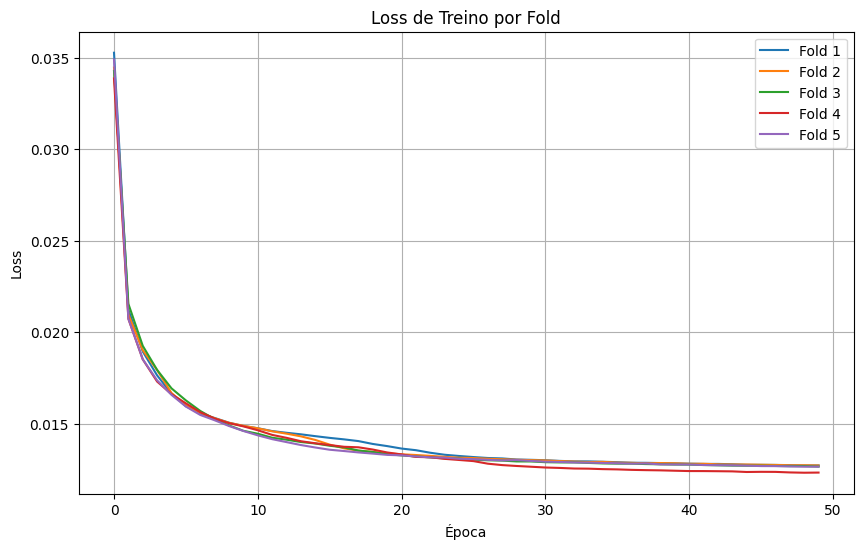

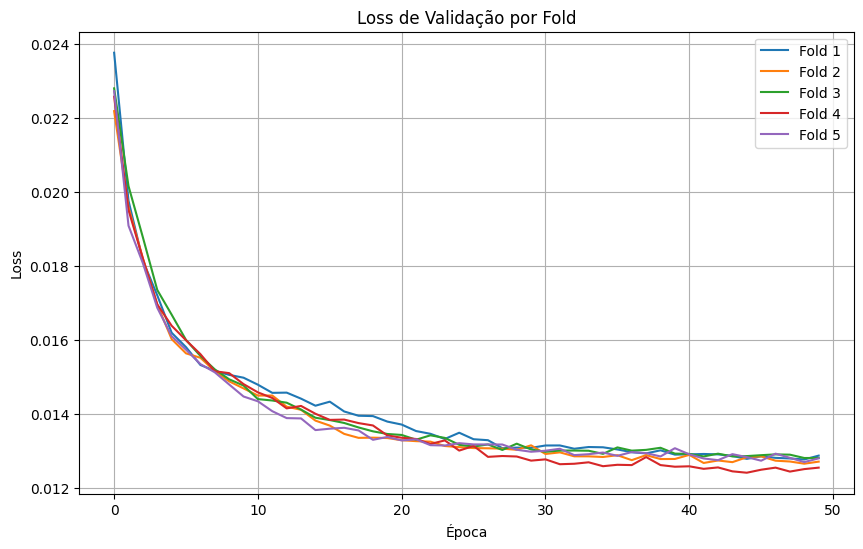

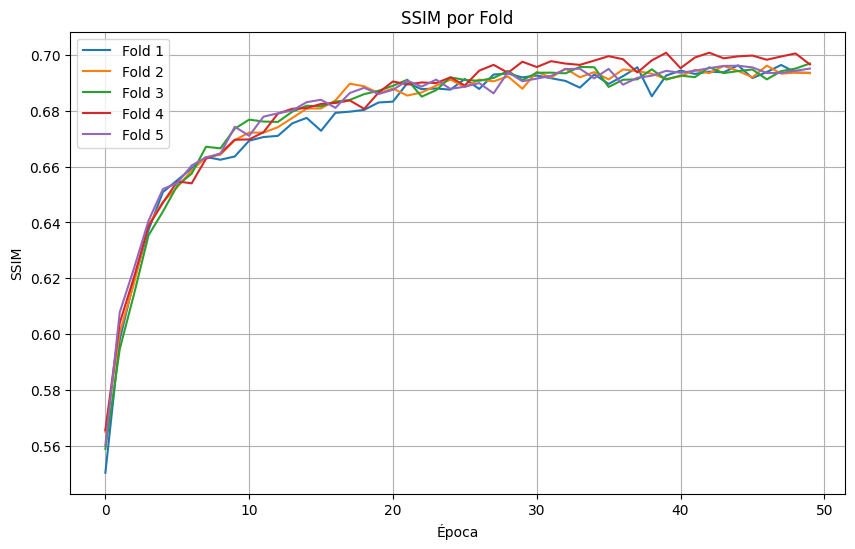

In [47]:
import matplotlib.pyplot as plt

# ----- LOSS DE TREINO -----
plt.figure(figsize=(10, 6))
for i, fold_losses in enumerate(all_train_losses):
    plt.plot(fold_losses, label=f"Fold {i+1}")
plt.title("Loss de Treino por Fold")
plt.xlabel("Época")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()

# ----- LOSS DE VALIDAÇÃO -----
plt.figure(figsize=(10, 6))
for i, fold_losses in enumerate(all_val_losses):
    plt.plot(fold_losses, label=f"Fold {i+1}")
plt.title("Loss de Validação por Fold")
plt.xlabel("Época")
plt.ylabel("Loss")
plt.legend()
plt.grid(True)
plt.show()

# ----- SSIM -----
plt.figure(figsize=(10, 6))
for i, fold_ssim in enumerate(all_ssim):
    plt.plot(fold_ssim, label=f"Fold {i+1}")
plt.title("SSIM por Fold")
plt.xlabel("Época")
plt.ylabel("SSIM")
plt.legend()
plt.grid(True)
plt.show()


In [41]:
import matplotlib.pyplot as plt

def show_autoencoder_results(model, loader, device='cuda', num_images=8):
    model.eval()

    images, _ = next(iter(loader))
    images = images.to(device)

    with torch.no_grad():
        x = images.view(-1, 28*28)
        z = model.encoder(x)           
        outputs = model.decoder(z)     

    outputs = outputs.view(-1, 1, 28, 28).cpu()
    images = images.cpu()
    z = z.cpu()

    plt.figure(figsize=(12, 6))
    for i in range(num_images):

        plt.subplot(3, num_images, i+1)
        plt.imshow(images[i].squeeze(), cmap='gray')
        plt.title("Input")
        plt.axis("off")
        
        plt.subplot(3, num_images, 2*num_images + i + 1)
        plt.imshow(outputs[i].squeeze(), cmap='gray')
        plt.title("Decoded")
        plt.axis("off")

    plt.tight_layout()
    plt.show()


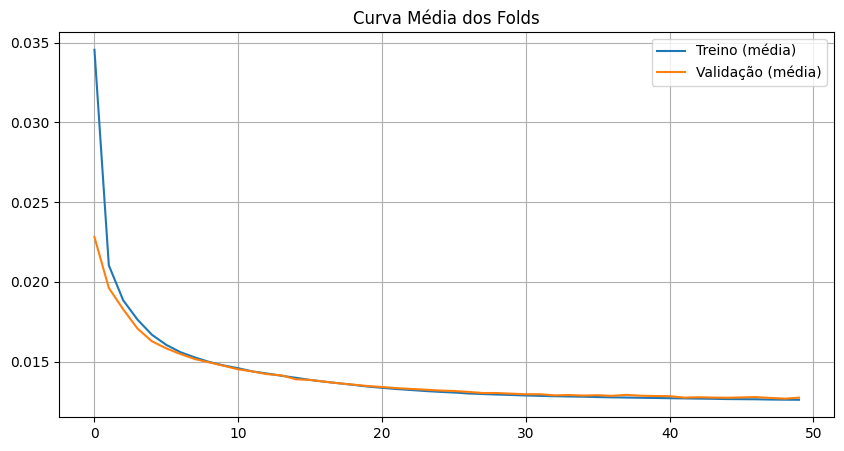

In [46]:
mean_train = np.mean(np.array(all_train_losses), axis=0)
mean_val = np.mean(np.array(all_val_losses), axis=0)
mean_ssim = np.mean(np.array(all_ssim), axis=0)

plt.figure(figsize=(10,5))
plt.plot(mean_train, label="Treino (média)")
plt.plot(mean_val, label="Validação (média)")
plt.legend()
plt.grid()
plt.title("Curva Média dos Folds")
plt.show()


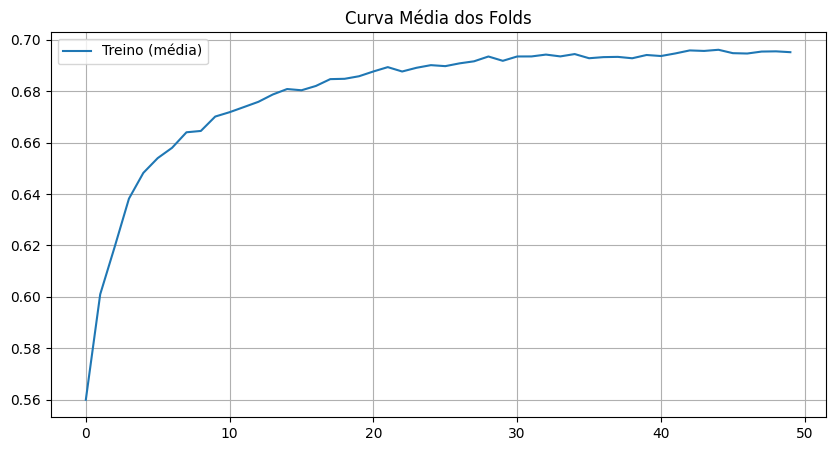

In [45]:
plt.figure(figsize=(10,5))
plt.plot(mean_ssim, label="Treino (média)")
plt.legend()
plt.grid()
plt.title("Curva Média dos Folds")
plt.show()

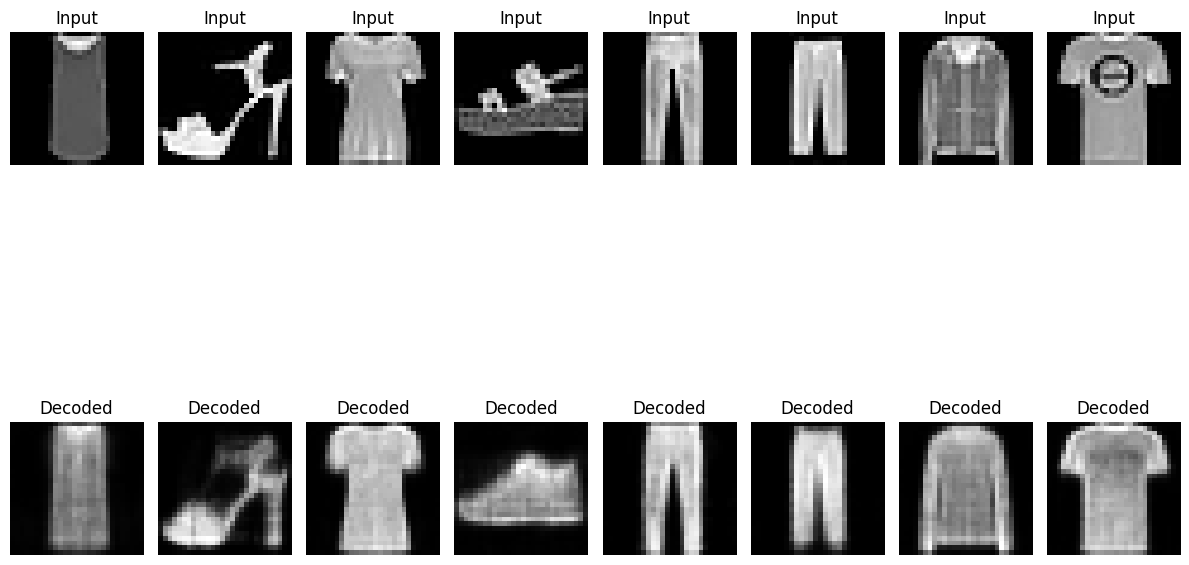

In [43]:
show_autoencoder_results(model, validation_loader, device)
